# Load Modules

In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
print(file_dir)
parent_dir = file_dir.parent
print(parent_dir)
sys.path.append(str(parent_dir))

C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython\vkprog_analyse
C:\Users\stc\Documents\GitHub\PredictiveAnalyticsPython


In [69]:
%load_ext autoreload
%autoreload
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pa_lib.data import (
    boxplot_histogram,
    clean_up_categoricals
    )
from pa_lib.file import (
    project_dir,
    load_bin,
    load_csv,
    load_xlsx
    )
from pa_lib.util import (
    cap_words
    
    )                     

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from IPython.display import display
pd.options.display.max_columns = None


In [23]:
from pa_lib.data import desc_col

In [138]:
## Lazy Recursive Job Dependency Request:
from pa_lib.job import request_job

################################################################################
## Recursive Dependency Check:
request_job(job_name="bd_prepare.py",  current= "Today") # output: bd_data.feather

15:34:07 [INFO] [ipykernel_launcher.py] requests 'bd_prepare.py'
15:34:07 [INFO] [ipykernel_launcher.py]: Not running job 'bd_prepare.py': result is current ('Today') from 2019-11-05 15:27:15.887908.


# Load Datasets

In [157]:
with project_dir("vkprog\\predictions"):
    #pred_rebuild_df = load_xlsx("20191104_rebuild_sales.xlsx")
    pred_rebuild_df = load_bin("20190701_pred_rebuild.feather")
    pred_rscript_df_raw = load_xlsx("20190701_EK_LIST_2W_KOMPLETT.xlsx")
    row_select = pred_rscript_df_raw.loc[:,"ENDKUNDE_NR"].map(lambda x: str(x).isdigit())
    pred_rscript_df = (
        pred_rscript_df_raw
        .loc[row_select,:]
        .astype({"ENDKUNDE_NR": "int64"})
        .rename(columns={"ENDKUNDE_NR": "Endkunde_NR"}))
    del pred_rscript_df_raw

with project_dir("vkprog"):
    bd_raw = load_bin("bd_data.feather").rename(
        mapper=lambda name: cap_words(name, sep="_"), axis="columns"
    )
    bd = bd_raw.loc[(bd_raw.Netto > 0)].pipe(clean_up_categoricals)
    del bd_raw
    

16:44:51 [INFO] Started loading binary file
16:44:51 [INFO] Reading from file C:\Users\stc\data\vkprog\predictions\20190701_pred_rebuild.feather
16:44:51 [INFO] Finished loading binary file in 0.0s (0.0s CPU)
16:44:51 [INFO] Started loading xlsx file
16:44:51 [INFO] Reading from file C:\Users\stc\data\vkprog\predictions\20190701_EK_LIST_2W_KOMPLETT.xlsx
16:44:53 [INFO] Finished loading xlsx file in 2.71s (2.72s CPU)
16:44:53 [INFO] Started loading binary file
16:44:53 [INFO] Reading from file C:\Users\stc\data\vkprog\bd_data.feather
16:44:54 [INFO] Finished loading binary file in 0.16s (1.33s CPU)


In [146]:
#desc_col(pred_rscript_df)

## DWH Data (actual reservations)

In [158]:
def customer_netto(KW_2, year):
    row_select = (
        # No cancellations/ Annulationen:
        (bd.loc[:,"Kampagnen_Status"] != 3)    &
        
        # Which two week period:
        (bd.loc[:,"Kamp_Erfass_KW_2"] == KW_2) &
        
        # Which year:
        (bd.loc[:,"Kamp_Erfass_Jahr"] == year) &
        
        # Only profitable campaigns:
        (bd.loc[:,"Netto"] >0)
        )

    reality_df = (bd
        .loc[row_select,:]
        .groupby(["Endkunde_NR","Kamp_Erfass_Jahr","Kamp_Erfass_KW_2"])
        .agg({"Netto": np.sum})
        .reset_index(inplace=False)
        )
    print(f"(year = {year}, KW_2 = {KW_2}), {reality_df.shape}")
    return reality_df

In [159]:
reality_2019_df = customer_netto(KW_2=27,year=2019)
reality_2018_df = customer_netto(KW_2=27,year=2018)

(year = 2019, KW_2 = 27), (621, 4)
(year = 2018, KW_2 = 27), (395, 4)


In [160]:
netto_sum_2018 = reality_2018_df.loc[:,"Netto"].sum()
print("Numbers from 2018, KW_2 == 45 :\n")
print(f"#Campaigns (Reservations):\n {reality_2018_df.shape[0]}")
print(f"Netto-Sum of Reservations:\n {netto_sum_2018}")


Numbers from 2018, KW_2 == 45 :

#Campaigns (Reservations):
 395
Netto-Sum of Reservations:
 8890023


In [196]:
comparision_df = (
    reality_2019_df
        #
        .merge(
            pred_rscript_df
            .loc[:,["Endkunde_NR","prob_KW27"]],
            on="Endkunde_NR",
            how="left"
        )
        .merge(
            pred_rebuild_df
            .loc[:,["Endkunde_NR","Prob_1"]],
            on="Endkunde_NR",
            how="left"
        )
        .fillna(value={"prob_KW27": 0, "Prob_1":0})
    )
comparision_df.sample(5)

,Endkunde_NR,Kamp_Erfass_Jahr,Kamp_Erfass_KW_2,Netto,prob_KW27,Prob_1
553,656949,2019,27,49,0.0,0.000000
24,106568,2019,27,3393,12.2,0.445598
23,106413,2019,27,8423,0.6,0.338425
251,492361,2019,27,85837,0.0,0.421042
427,612699,2019,27,3500,0.0,0.000000


In [197]:
display(desc_col(comparision_df))
display(comparision_df.describe())

,DTYPE,NULLS,UNIQUE
Endkunde_NR,int64,0/621,621
Kamp_Erfass_Jahr,category,0/621,1
Kamp_Erfass_KW_2,category,0/621,1
Netto,int64,0/621,469
prob_KW27,float64,0/621,133
Prob_1,float64,0/621,310


,Endkunde_NR,Netto,prob_KW27,Prob_1
count,621.000000,621.000000,621.000000,621.000000
mean,448649.442834,12926.732689,5.897101,0.164513
std,216349.448993,36088.196706,16.238906,0.185861
min,100128.000000,49.000000,0.000000,0.000000
25%,146287.000000,1554.000000,0.000000,0.000000
50%,545943.000000,3521.000000,0.700000,0.000000
75%,632300.000000,8115.000000,3.300000,0.342759
max,660943.000000,532605.000000,99.800000,0.600488


In [198]:
row_select = ~comparision_df.loc[:,"Prob_1"].isna() #
print(comparision_df.loc[row_select,"Netto"].sum())

row_select = ~comparision_df.loc[:,"prob_KW27"].isna() #
print(comparision_df.loc[row_select,"Netto"].sum())

8027501
8027501


In [201]:
comparision_df = (
    comparision_df
        .eval("Netto_rscript = prob_KW27 * Netto * 0.01")
        .eval("Netto_rebuild = Prob_1    * Netto ")
    )

In [202]:
comparision_df.head()

,Endkunde_NR,Kamp_Erfass_Jahr,Kamp_Erfass_KW_2,Netto,prob_KW27,Prob_1,Netto_rscript,Netto_rebuild
0,100128,2019,27,1720,0.0,0.000000,0.000,0.000000
1,100641,2019,27,10570,1.1,0.350646,116.270,3706.328198
2,100648,2019,27,42467,22.6,0.000000,9597.542,0.000000
3,100675,2019,27,5000,0.0,0.000000,0.000,0.000000
4,101160,2019,27,3500,0.0,0.000000,0.000,0.000000


In [210]:
comparision_df.describe()

,Endkunde_NR,Netto,prob_KW27,Prob_1,Netto_rscript,Netto_rebuild
count,621.000000,621.000000,621.000000,621.000000,621.000000,621.000000
mean,448649.442834,12926.732689,5.897101,0.164513,2016.603372,2586.295143
std,216349.448993,36088.196706,16.238906,0.185861,12945.151367,9290.898123
min,100128.000000,49.000000,0.000000,0.000000,0.000000,0.000000
25%,146287.000000,1554.000000,0.000000,0.000000,0.000000,0.000000
50%,545943.000000,3521.000000,0.700000,0.000000,12.180000,0.000000
75%,632300.000000,8115.000000,3.300000,0.342759,147.210000,1193.549519
max,660943.000000,532605.000000,99.800000,0.600488,239601.728000,98474.322521


In [206]:
comparision_df.agg({"Netto_rscript": sum, "Netto_rebuild": sum})

Netto_rscript    1.252311e+06
Netto_rebuild    1.606089e+06
dtype: float64

In [209]:
1.6*np.power(10,6)

1600000.0

ValueError: cannot convert float NaN to integer

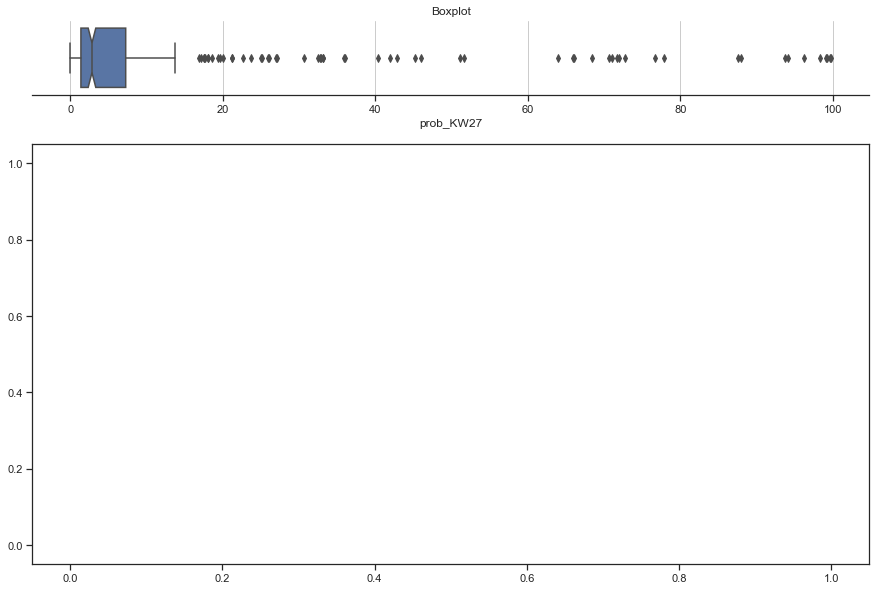

In [182]:
boxplot_histogram(comparision_df.loc[:,"prob_KW27"])
boxplot_histogram(comparision_df.loc[:,"Prob_1"])

In [174]:
comparision_df.sort_values("Prob_1")

,Endkunde_NR,Kamp_Erfass_Jahr,Kamp_Erfass_KW_2,Netto,prob_KW27,Prob_1
0,100128,2019,27,1720,0.0,0.000000
397,597681,2019,27,4300,0.0,0.000000
394,595393,2019,27,2098,0.0,0.000000
393,595217,2019,27,3000,0.0,0.000000
391,594720,2019,27,300,0.0,0.000000
390,594402,2019,27,3000,0.0,0.000000
389,594220,2019,27,2500,0.0,0.000000
387,593534,2019,27,1400,0.0,0.000000
386,593532,2019,27,2000,0.0,0.000000
384,592303,2019,27,6000,0.0,0.000000
